# Caso Práctico Final: Optimización de Campaña de Marketing Online
![Imagen de Portada](https://static.vecteezy.com/system/resources/thumbnails/027/303/356/small_2x/digital-marketing-commerce-online-sale-concept-promotion-of-products-or-services-through-digital-channels-search-engine-social-media-email-website-digital-marketing-strategies-and-goals-seo-ppc-photo.jpg)

**Proyecto final de la materia _Inteligencia Artificial para la Empresa_**  
**Autor:** Diego Cesar Lerma Torres

**IMF Smart Education x Universidad Católica de Ávila**

![IMF](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRRMUC5omrUXL-ptQ-K3XmrU03vLjEg7nNzsw&s)

En este trabajo se aplicará el **algoritmo de Multi-Armed Bandit** para maximizar la atención de los usuarios y, en consecuencia, las visitas a una página web promocional.

---

## Descripción del Desafío

Se ha lanzado una campaña de marketing online para promocionar un producto innovador. El equipo de diseño ha elaborado **5 imágenes diferentes** del producto, las cuales se exhibirán en un banner publicitario. Dado que desconocemos a priori cuál de estas imágenes captará mayor atención, el desafío consiste en:

> **Objetivo:** Identificar la imagen que genere el mayor número de clics, es decir, aquella que logre maximizar el ratio de conversión definido como:
>
> $$
> Q(\text{imagen}_i) = \frac{\text{Nº Clicks}}{\text{Nº Impresiones de la página}}
> $$
>
> Buscamos determinar la imagen óptima:
>
> $$
> Q(\text{imagen}^{*}) = \max \{ Q(\text{imagen}_1), Q(\text{imagen}_2), \dots, Q(\text{imagen}_5) \}
> $$

La efectividad de cada imagen se mide en función de su rendimiento, y es necesario aprender a partir de los clics generados sobre el banner qué imagen resulta más atractiva para los usuarios.

---

## Estrategia de Resolución: El Algoritmo Multi-Armed Bandit

El **Multi-Armed Bandit (MAB)** es un problema clásico en teoría de la decisión y en aprendizaje por refuerzo, que se ilustra mediante la metáfora de una máquina tragamonedas con múltiples brazos. Cada brazo representa una alternativa (en este caso, una imagen publicitaria) que ofrece recompensas inciertas. El objetivo es maximizar la ganancia acumulada a lo largo del tiempo, equilibrando dos aspectos fundamentales:

- **Exploración:** Probar opciones nuevas o poco evaluadas para descubrir su potencial.  
- **Explotación:** Aprovechar el conocimiento acumulado seleccionando la opción que hasta el momento ha mostrado mejores resultados.

Este equilibrio es esencial para evitar descartar imágenes que, aunque inicialmente poco probadas, podrían tener un rendimiento superior a largo plazo.

![Bandido Multi-Brazo](https://media.licdn.com/dms/image/v2/C4D12AQEGFgjM7YZpYg/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1618176729724?e=2147483647&v=beta&t=tJaR7QLD9jbkYAdep9zrwFFzl3RAJyKnr6MtDqARkoc)  
*Figura 1.*

### Estrategias Relevantes

Existen diversas técnicas para abordar el problema MAB, de las cuales se destacan:

- **Epsilon-Greedy:**  
  Con una probabilidad *ε* se elige una imagen al azar (exploración) y, con una probabilidad *(1 - ε)* se selecciona la imagen que históricamente ha obtenido la mayor recompensa (explotación). Esta estrategia es sencilla, intuitiva y se adapta bien a entornos donde la recompensa puede variar con el tiempo.

- **Upper Confidence Bound (UCB):**  
  Selecciona la imagen que maximiza una combinación entre la recompensa media observada y una medida de incertidumbre. Esto permite que, además de aprovechar las imágenes con buen desempeño, se exploren aquellas con menor evidencia pero que podrían resultar prometedoras.

- **Thompson Sampling:**  
  Utiliza un enfoque bayesiano para asignar probabilidades a cada imagen de ser la óptima. Esta técnica equilibra de forma natural la exploración y explotación, adaptándose continuamente a la información obtenida durante la campaña.

---

## Actividad y Preguntas a Resolver

Partiendo de la función implementada en el notebook, se deberá experimentar con el valor de *ε* para responder, directamente en el entorno interactivo, a las siguientes cuestiones:

1. **Valor óptimo de ε:** ¿Cuál es el valor de *ε* que maximiza el número de clics de la imagen ganadora?
2. **Imagen ganadora y sus clics:** ¿Cuál es la imagen que, tras la optimización, obtiene el mayor número de clics y cuántos clics son?
3. **Escenario 100% explotación:** ¿Qué resultado se obtiene al aplicar una ratio de explotación del 100% (es decir, sin exploración)?

El análisis de estas preguntas permitirá asentar los conceptos fundamentales del aprendizaje por refuerzo y la aplicación práctica del algoritmo Multi-Armed Bandit en la optimización de campañas de marketing online.

In [289]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [290]:
num_bandits = 5
random.seed(42)

def generate_bandits(num_bandits=5):
    bandits = [round(random.random(), 2) for _ in range(num_bandits)]
    return bandits

"""
Generamos los bandidos aleatoriamente para asegurarnos de no conocer a priori cuál es el mejor.
Estos serán mostrados al final del experimento,
para comprobar si el algoritmo ha encontrado el mejor.
"""
random_generated_bandits = generate_bandits(num_bandits)

num_games = 1000
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [291]:
def multi_armed_bandit(bandits=random_generated_bandits, num_games=1000, epsilon=0.1, verbose=False):
    
    total_reward = 0
    acum_reward_bandit = np.zeros(len(bandits))
    num_selected_bandit = np.zeros(len(bandits))
    q_bandits = np.zeros(len(bandits))
    
    if verbose:
        print("Initial Bandits Distribution\n  {}".format(bandits))
    
    for game in range(0,num_games):
        
        old_q_bandits = q_bandits.copy()
        
        if np.random.random() < epsilon:
            bandit = np.random.randint(len(bandits)) # Exploro
        else:
            bandit = np.random.choice(np.flatnonzero(q_bandits == q_bandits.max())) # Exploto 
            
        # Obtengo el reward
        reward = 1 if (np.random.random() < bandits[bandit]) else 0
        
        # Actualizo reward total
        total_reward += reward
        
        # Actualizo valor (Q) de la imagen
        acum_reward_bandit[bandit] += reward
        num_selected_bandit[bandit] += 1
        q_bandits[bandit] = acum_reward_bandit[bandit] / num_selected_bandit[bandit]
        
        if verbose:
            print("\nGAME {game}\n  Old Q_Bandits = {old_q_bandits}\n  Selected Bandit = {bandit} \
                  \n  Reward = {reward}\n  Q_Bandits = {q_bandits}"
                  .format(game=game+1, old_q_bandits=old_q_bandits, bandit=bandit, 
                          reward=reward, q_bandits=q_bandits))
    
    return bandits, total_reward, q_bandits, num_selected_bandit

## 1. ¿Cual es el valor de EPSILON que máximiza la imagen con mayor número de clicks?

### Corremos el experimento una vez para cada valor de EPSILON y obtenemos el mejor EPSILON.

Los bandidos eran: [0.64, 0.03, 0.28, 0.22, 0.74]
El mejor bandido era el: 4, con una probabilidad de 0.74 
    Epsilon  Mejor Bandido  Clicks Mejor Bandido  Recompensa Total
0      0.01              0                   639               641
1      0.05              4                   697               709
2      0.10              0                   582               602
3      0.20              4                   566               677
4      0.30              4                   548               642
5      0.40              4                   506               599
6      0.50              4                   462               555
7      0.60              4                   399               527
8      0.70              4                   338               499
9      0.80              4                   235               421
10     0.90              4                   198               403
11     1.00              4                   151               400

El mejor epsilon fue

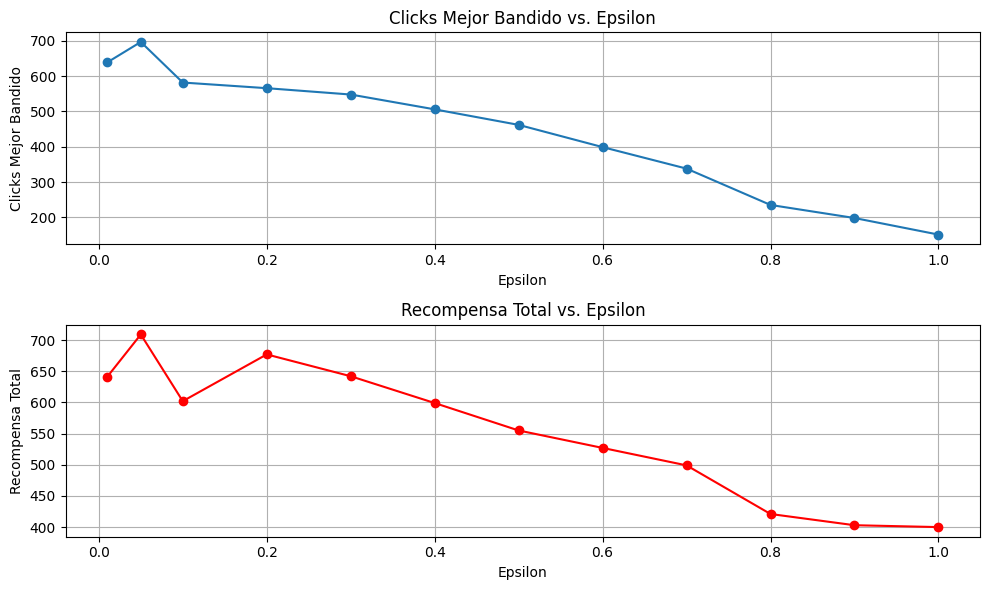

In [292]:
def multi_armed_bandit(bandits, num_games=1000, epsilon=0.1, verbose=False):
    total_reward = 0
    acum_reward_bandit = np.zeros(len(bandits))
    num_selected_bandit = np.zeros(len(bandits))
    q_bandits = np.zeros(len(bandits))

    if verbose:
        print("Initial Bandits Distribution\n  {}".format(bandits))

    for game in range(0, num_games):
        old_q_bandits = q_bandits.copy()

        if np.random.random() < epsilon:
            bandit = np.random.randint(len(bandits))  # Exploro
        else:
            bandit = np.random.choice(np.flatnonzero(q_bandits == q_bandits.max()))  # Exploto

        reward = 1 if (np.random.random() < bandits[bandit]) else 0
        total_reward += reward
        acum_reward_bandit[bandit] += reward
        num_selected_bandit[bandit] += 1
        q_bandits[bandit] = acum_reward_bandit[bandit] / num_selected_bandit[bandit]

        if verbose:
            print("\nGAME {game}\n  Old Q_Bandits = {old_q_bandits}\n  Selected Bandit = {bandit} \
                  \n  Reward = {reward}\n  Q_Bandits = {q_bandits}"
                  .format(game=game + 1, old_q_bandits=old_q_bandits, bandit=bandit,
                          reward=reward, q_bandits=q_bandits))

    return bandits, total_reward, q_bandits, num_selected_bandit

def find_best_epsilon(num_games=1000, epsilon_values=None):
    if epsilon_values is None:
        epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    results = []
    for epsilon in epsilon_values:
        bandits = random_generated_bandits
        _, total_reward, q_bandits, num_selected_bandit = multi_armed_bandit(bandits, num_games, epsilon)
        best_bandit_index = np.argmax(q_bandits)
        best_bandit_clicks = int(num_selected_bandit[best_bandit_index] * q_bandits[best_bandit_index])
        results.append({
            'Epsilon': epsilon,
            'Mejor Bandido': best_bandit_index,
            'Clicks Mejor Bandido': best_bandit_clicks,
            'Recompensa Total': total_reward,
        })

    df = pd.DataFrame(results)
    best_epsilon = df.loc[df['Clicks Mejor Bandido'].idxmax()]['Epsilon']
    return df, best_epsilon

def plot_epsilon_results(df_results):
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(df_results['Epsilon'], df_results['Clicks Mejor Bandido'], marker='o', linestyle='-')
    plt.xlabel('Epsilon')
    plt.ylabel('Clicks Mejor Bandido')
    plt.title('Clicks Mejor Bandido vs. Epsilon')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(df_results['Epsilon'], df_results['Recompensa Total'], marker='o', linestyle='-', color='r')
    plt.xlabel('Epsilon')
    plt.ylabel('Recompensa Total')
    plt.title('Recompensa Total vs. Epsilon')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

df_results, best_epsilon = find_best_epsilon(num_games, epsilon_values)
best_bandit_index = np.argmax(random_generated_bandits)
print(f"Los bandidos eran: {random_generated_bandits}")
print(f"El mejor bandido era el: {best_bandit_index}, "
      f"con una probabilidad de {random_generated_bandits[best_bandit_index]} ")
print(df_results)
print(f"\nEl mejor epsilon fue: {best_epsilon}")

plot_epsilon_results(df_results)


In [293]:
print(f"El mejor epsilon fue: {best_epsilon}\n")

El mejor epsilon fue: 0.05



### Ahora corremos el experimento completo 1000 veces y obtenemos los 3 valores de EPSILON que mejor resultado obtuvieron.

In [294]:
def find_top_n_epsilon(num_iterations=100, num_games=1000, epsilon_values=None, top_n=3):
    """
    Corremos el experimento múltiples veces para encontrar los N epsilon que mejor resultado obtienen.

    Args:
        num_iterations: Número de veces que corremos el experimento.
        num_games: Número de partidas por experimento.
        epsilon_values: Lista de valores de epsilon a probar.
        top_n: Número de valores de epsilon superiores a devolver.

    Returns:
        Un DataFrame mostrando cuantas veces cada valor de epsilon fue el mejor.
        Los N valores de epsilon superiores.
    """
    best_epsilon_counts = {}
    for _ in range(num_iterations):
        _, best_epsilon = find_best_epsilon(num_games, epsilon_values)
        best_epsilon_counts[best_epsilon] = best_epsilon_counts.get(best_epsilon, 0) + 1

    df_counts = pd.DataFrame(best_epsilon_counts.items(), columns=['Epsilon', 'Total de veces que fue el mejor'])
    df_counts = df_counts.sort_values('Total de veces que fue el mejor', ascending=False)

    top_n_epsilons = df_counts['Epsilon'].head(top_n).tolist()

    return df_counts, top_n_epsilons

num_iterations = 1000
top_n = 3

df_epsilon_counts, top_epsilons = find_top_n_epsilon(num_iterations, num_games, epsilon_values, top_n)

print("Cuenta de cuantas veces cada epsilon fue el mejor:")
print(df_epsilon_counts)
print(f"\nLos {top_n} epsilon que mejor resultado obtuvieron: {top_epsilons}")

Cuenta de cuantas veces cada epsilon fue el mejor:
   Epsilon  Total de veces que fue el mejor
0     0.01                              419
1     0.05                              349
2     0.10                              205
3     0.20                               26
4     0.30                                1

Los 3 epsilon que mejor resultado obtuvieron: [0.01, 0.05, 0.1]


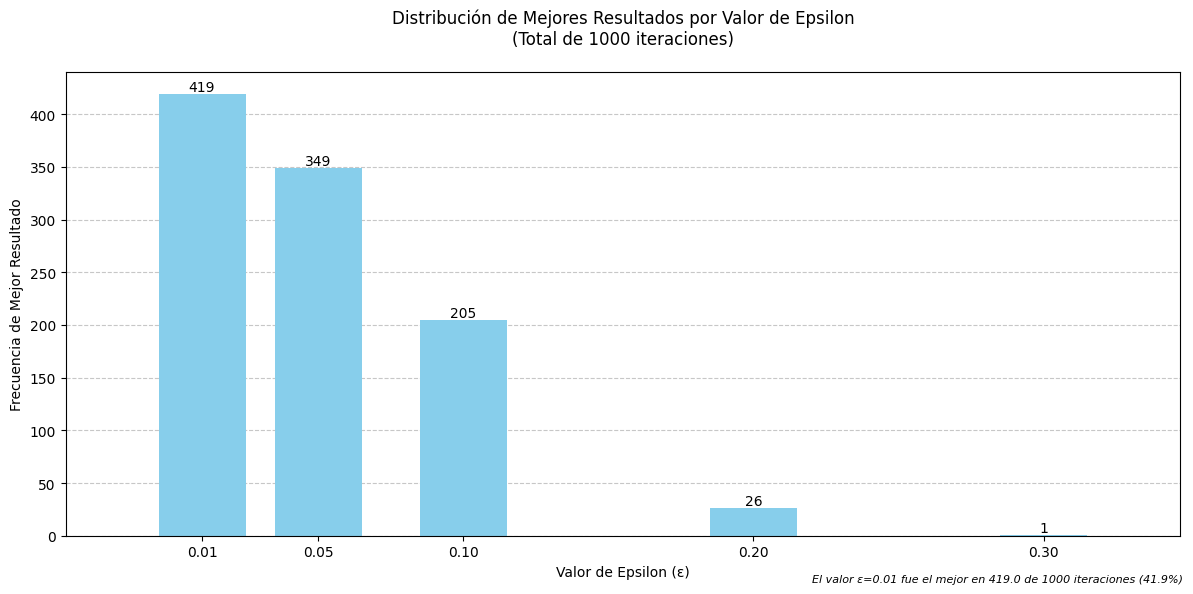

In [295]:
def plot_epsilon_counts(df_epsilon_counts):
    """
    Grafica el resultado de find_top_n_epsilon mostrando la distribución
    de éxitos para cada valor de epsilon.

    Args:
        df_epsilon_counts: DataFrame con las columnas 'Epsilon' y 'Total de veces que fue el mejor'
    """
    df_sorted = df_epsilon_counts.sort_values('Epsilon')
    
    plt.figure(figsize=(12, 6))
    
    bars = plt.bar(df_sorted['Epsilon'], 
                  df_sorted['Total de veces que fue el mejor'],
                  color='skyblue', 
                  width=0.03)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    plt.xlabel('Valor de Epsilon (ε)', fontsize=10)
    plt.ylabel('Frecuencia de Mejor Resultado', fontsize=10)
    plt.title('Distribución de Mejores Resultados por Valor de Epsilon\n'
             f'(Total de {df_epsilon_counts["Total de veces que fue el mejor"].sum()} iteraciones)',
             fontsize=12, pad=20)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
    
    plt.rcParams['axes.axisbelow'] = True
    
    plt.margins(x=0.1)
    
    plt.xticks(df_sorted['Epsilon'], [f'{x:.2f}' for x in df_sorted['Epsilon']], 
               rotation=0)
    
    total_iterations = df_epsilon_counts['Total de veces que fue el mejor'].sum()
    best_epsilon = df_epsilon_counts.iloc[0]
    plt.figtext(0.99, 0.02, 
                f'El valor ε={best_epsilon["Epsilon"]:.2f} fue el mejor en '
                f'{best_epsilon["Total de veces que fue el mejor"]} de {total_iterations} iteraciones '
                f'({best_epsilon["Total de veces que fue el mejor"]/total_iterations*100:.1f}%)',
                ha='right', fontsize=8, style='italic')
    
    plt.tight_layout()
    plt.show()
    

plot_epsilon_counts(df_epsilon_counts)

## Respuesta 1

Entonces, respondiendo a la pregunta:

>¿Cuáles el valor de épsilon que maximiza la imagen con mayor número de clics?

**Hasta ahora hemos realizado lo siguiente:**

1. Generamos 5 bandidos con probabilidades de éxito distintas.
2. Hemos corrido el experimento 1000 veces para cada valor de EPSILON.
3. Hemos obtenido los 3 valores de EPSILON que mejor resultado obtuvieron.

**Podemos obtener como conclusión que:**

Los mejores valores de EPSILON suelen estar entre 0.01 y 0.1.

**Explicación:**

Se ha observado que cuando el valor de EPSILON es _demasiado alto_, el algoritmo **explotará** demasiado rápido y no **explorará** suficiente, lo que puede llevar a que no se encuentren los mejores resultados.

Por otro lado, si el valor de EPSILON es _demasiado bajo_, el algoritmo **explorará** demasiado poco y no **explotará** suficientemente, lo que puede llevar a que no se encuentren los mejores resultados.

>Con un valor de EPSILON entre 0.01 y 0.1 se consigue un buen equilibrio entre exploración y explotación, lo que permite encontrar los mejores resultados.

## 2. ¿Cuál es la imagen que más clics obtiene y cuántos?

In [307]:
print(df_results)
best_row = df_results.loc[df_results['Clicks Mejor Bandido'].idxmax()]
best_bandit_index = best_row['Mejor Bandido']
best_clicks = best_row['Clicks Mejor Bandido']
best_epsilon = best_row['Epsilon']
print(f"{'_'*100}"
      f"\n\nLa imagen que más clics obtiene es la imagen {best_bandit_index}"
      f" con {best_clicks} clics. Este valor se obtuvo con un epsilon de {best_epsilon}"
      f"\n\n{'_'*100}")

print(f"Este valor es adecuado, ya que podemos comprobarlo con los bandidos originales:\n{random_generated_bandits}")
print(f"El mejor bandido era objetivamente el: {np.argmax(random_generated_bandits)}")

    Epsilon  Mejor Bandido  Clicks Mejor Bandido  Recompensa Total
0      0.01              0                   639               641
1      0.05              4                   697               709
2      0.10              0                   582               602
3      0.20              4                   566               677
4      0.30              4                   548               642
5      0.40              4                   506               599
6      0.50              4                   462               555
7      0.60              4                   399               527
8      0.70              4                   338               499
9      0.80              4                   235               421
10     0.90              4                   198               403
11     1.00              4                   151               400
____________________________________________________________________________________________________

La imagen que más clics obt

## Respuesta 2

Entonces, respondiendo a la pregunta:

>¿Cuáles la imagen que más clics obtiene y cuántos?

**Podemos obtener como conclusión que:**

La imagen que más clics se puede observar en la tabla de arriba.

## 3. Poniendo una ratio de explotación del 100%, ¿Qué resultado se obtiene?

In [297]:
# Ejecutamos el experimento con un epsilon de 1
bandits_100, total_reward_100, q_bandits_100, num_selected_bandit_100 = multi_armed_bandit(random_generated_bandits, num_games, 1)

print(f"El total de recompensas obtenidas con un epsilon de 1 es de {total_reward_100}")

bandits_001, total_reward_001, q_bandits_001, num_selected_bandit_001 = multi_armed_bandit(random_generated_bandits, num_games, 0.01)

print(f"El total de recompensas obtenidas con un epsilon de 0.01 es de {total_reward_001}")

print(f"\nCuando el epsilon es 1, el algoritmo explota demasiado rápido y no explora lo suficiente."
      f"\nEsto se traduce en una pérdida de recompensas de {total_reward_001 - total_reward_100} clics.")


El total de recompensas obtenidas con un epsilon de 1 es de 372
El total de recompensas obtenidas con un epsilon de 0.01 es de 768

Cuando el epsilon es 1, el algoritmo explota demasiado rápido y no explora lo suficiente.
Esto se traduce en una pérdida de recompensas de 396 clics.


## Respuesta 3

Entonces, respondiendo a la pregunta:

>Poniendo una ratio de explotación del 100%, ¿Qué resultado se obtiene?

**Podemos obtener como conclusión que:**

Cuando el epsilon (ratio de explotación) es 1, el algoritmo explotará demasiado rápido y no explorará lo suficiente, lo que llevará a que no se encuentren los mejores resultados.

# Conclusiones

El Bandido Multi-Brazo (MAB) es una técnica de aprendizaje por refuerzo ideal para optimizar la toma de decisiones en tiempo real, como en marketing online, donde se busca maximizar clics o conversiones.  Su principal fortaleza radica en equilibrar *exploración* (probar nuevas opciones) y *explotación* (usar las opciones que ya funcionan bien).

**Ventajas Clave:**

1.  **Adaptabilidad:** Aprende y se adapta continuamente a medida que recibe *feedback* (p.ej., clics), sin necesidad de modelos predefinidos.
2.  **Eficiencia:** Maximiza la recompensa total (p.ej., clics) al dirigir más recursos a las mejores opciones *mientras aprende*.  Esto es más eficiente que las pruebas A/B tradicionales, que requieren un período de prueba fijo.
3.  **Optimización Continua:**  A diferencia de las pruebas A/B, que se detienen después de un período, el MAB optimiza *constantemente*.

**Limitaciones y Consideraciones:**

1.  **Exploración Inicial Necesaria:** Al principio, debe mostrar opciones subóptimas para aprender.  Esto es inherente al proceso de aprendizaje.
2.  **Complejidad (Avanzada):**  Ajustar los parámetros (como el "epsilon" en epsilon-greedy) puede requerir experiencia.  La complejidad aumenta con muchas opciones (brazos).
3.  **Contexto Limitado (MAB Básico):** El MAB estándar no considera información contextual del usuario (p.ej., demografía).  Los *Contextual Bandits* son una extensión que sí lo hace.

**MAB vs. Otras Técnicas:**

*   **A/B Testing:**  MAB es *adaptativo* y *continuo*.  A/B testing es *estático* y *discontinuo* (requiere detenerse para analizar).
*   **Modelos de Markov (RL-MDP):** MAB es un caso especial de MDP (un solo estado).  MDPs modelan *secuencias* de decisiones con consecuencias a largo plazo, mientras que MAB se enfoca en la *recompensa inmediata*.

**En Resumen:** El MAB es excelente para optimización en línea donde la adaptación continua y el equilibrio exploración-explotación son cruciales.  Aunque requiere cierta configuración y tiene limitaciones, su eficiencia y capacidad de aprendizaje lo hacen muy valioso.